# DEFINICIÓN DE PARÁMETROS

In [1]:
#######################################################################################################################

# Ruta hacia los CSV del dataset
train_file_relative = './data/700Train.csv'
validation_file_relative = './data/700Validation.csv'
test_file_relative = './data/700Test.csv'

# Ruta al directorio de imágenes con máscara aplicada
masked_dir_relative = '../local/output_masked'
edited_dir_relative = '../local/output_edited'

model_dir_relative = "./models"

# Ruta relativa hacia la librería ai4eutils
ai4eutils_relative = "./repos/ai4eutils"

# Ruta relativa hacia la librería CameraTraps
CameraTraps_relative = "./repos/CameraTraps"

#######################################################################################################################

# DEFINICIÓN PARÁMETROS CNN

In [2]:
#######################################################################################################################

EPOCHS = 50
LEARNING_RATE = 1e-4
BATCH_SIZE = 16

IMG_HEIGHT = IMG_WIDTH = 448

#######################################################################################################################

In [3]:
import os
import platform

import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras

from modules.dataset_utils import DatasetUtils

home = os.path.expanduser("~")

ai4utils = os.path.abspath(ai4eutils_relative)
CameraTraps = os.path.abspath(CameraTraps_relative)
train_file = os.path.abspath(train_file_relative)
validation_file = os.path.abspath(validation_file_relative)
test_file = os.path.abspath(test_file_relative)
masked_dir = os.path.abspath(masked_dir_relative)
edited_dir = os.path.abspath(edited_dir_relative)
model_dir = os.path.abspath(model_dir_relative)

try:
    os.environ['PYTHONPATH']
except KeyError:
    os.environ['PYTHONPATH'] = ""
if platform.system() == 'Windows':
    os.environ['PYTHONPATH'] += (";" + ai4utils)
    os.environ['PYTHONPATH'] += (";" + CameraTraps)
else:
    os.environ['PYTHONPATH'] += (":" + ai4utils)
    os.environ['PYTHONPATH'] += (":" + CameraTraps)

print('==============================================================================================================')
print('PYTHONPATH: ' + os.environ['PYTHONPATH'])
print('')
print('ai4eutils PATH: ' + '\t\t' + ai4utils)
print('CameraTraps PATH: ' + '\t\t' + CameraTraps)
print('Train CSV PATH: ' + '\t\t' + train_file)
print('Validation CSV PATH: ' + '\t' + validation_file)
print('Test CSV PATH: ' + '\t\t\t' + test_file)
print('masked PATH: ' + '\t\t\t' + masked_dir)
print('edited PATH: ' + '\t\t\t' + edited_dir)
print('models PATH: ' + '\t\t\t' + model_dir)
print('==============================================================================================================')


TensorFlow version: 2.10.0
Is GPU available? tf.test.is_gpu_available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

PYTHONPATH: /Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo:/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/ai4eutils:/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/CameraTraps

ai4eutils PATH: 		/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/ai4eutils
CameraTraps PATH: 		/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/CameraTraps
Train CSV PATH: 		/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/data/700Train.csv
Validation CSV PATH: 	/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/data/700Validation.csv
Test CSV PATH: 			/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/data/700Test.csv
masked PATH: 			/Users/carlos/WORKSPACE/local/output_masked
edited PATH: 			/Users/carlos/WORKSPACE/local/output_edited
models PATH: 			/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/models


# Generate Datasets

In [4]:
custom = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
)

general = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

file_names, labels = DatasetUtils.load_dataset(train_file, edited_dir)
d = {'file_names': file_names, 'labels': labels}
train_df = pd.DataFrame(data=d, dtype=str)
train_dataset = custom.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col="file_names",
    y_col="labels",
    class_mode='binary',
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

file_names, labels = DatasetUtils.load_dataset(validation_file, edited_dir)
d = {'file_names': file_names, 'labels': labels}
validation_df = pd.DataFrame(data=d, dtype=str)
validation_dataset = general.flow_from_dataframe(
    dataframe=validation_df,
    x_col="file_names",
    y_col="labels",
    class_mode='binary',
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

file_names, labels = DatasetUtils.load_dataset(test_file, edited_dir)
d = {'file_names': file_names, 'labels': labels}
test_df = pd.DataFrame(data=d, dtype=str)
test_dataset = general.flow_from_dataframe(
    dataframe=test_df,
    x_col="file_names",
    y_col="labels",
    class_mode='binary',
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 1450 validated image filenames belonging to 2 classes.
Found 312 validated image filenames belonging to 2 classes.
Found 311 validated image filenames belonging to 2 classes.


# VGG 16 Architecture

In [5]:
VGG16 = keras.Sequential()
VGG16.add(keras.layers.Conv2D(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), filters=64, kernel_size=(3, 3), padding="same", activation="relu"))

VGG16.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation="relu"))
VGG16.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

VGG16.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
VGG16.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
VGG16.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

VGG16.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
VGG16.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
VGG16.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
VGG16.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

VGG16.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
VGG16.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
VGG16.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
VGG16.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

VGG16.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
VGG16.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
VGG16.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
VGG16.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

VGG16.add(keras.layers.Flatten())
VGG16.add(keras.layers.Dense(units=1024,activation="relu"))
VGG16.add(keras.layers.Dense(units=1024,activation="relu"))

VGG16.add(keras.layers.Dense(1, activation='sigmoid'))

VGG16.summary()

VGG16.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[keras.losses.BinaryCrossentropy()],
    metrics=['accuracy'])

Metal device set to: Apple M1


2022-10-18 13:25:47.840768: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-18 13:25:47.841064: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 448, 448, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 448, 448, 16)      9232      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 224, 224, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                    

Epoch 1/50


2022-10-18 13:25:48.293444: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-18 13:25:48.827104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


90/90 [==============================] - ETA: 0s - loss: 0.4879 - accuracy: 0.8061

2022-10-18 13:27:08.302123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


90/90 [==============================] - 84s 918ms/step - loss: 0.4879 - accuracy: 0.8061 - val_loss: 0.3496 - val_accuracy: 0.8651
Epoch 2/50
90/90 [==============================] - 82s 914ms/step - loss: 0.3475 - accuracy: 0.8919 - val_loss: 0.3045 - val_accuracy: 0.9178
Epoch 3/50
90/90 [==============================] - 83s 917ms/step - loss: 0.3330 - accuracy: 0.8954 - val_loss: 0.2877 - val_accuracy: 0.9145
Epoch 4/50
90/90 [==============================] - 82s 913ms/step - loss: 0.3252 - accuracy: 0.8919 - val_loss: 0.2966 - val_accuracy: 0.9178
Epoch 5/50
90/90 [==============================] - 82s 912ms/step - loss: 0.3197 - accuracy: 0.8989 - val_loss: 0.2736 - val_accuracy: 0.9178
Epoch 6/50
90/90 [==============================] - 82s 916ms/step - loss: 0.3146 - accuracy: 0.8975 - val_loss: 0.2670 - val_accuracy: 0.9211
Epoch 7/50
90/90 [==============================] - 82s 915ms/step - loss: 0.3060 - accuracy: 0.8975 - val_loss: 0.2850 - val_accuracy: 0.9178
Epoch 8/50

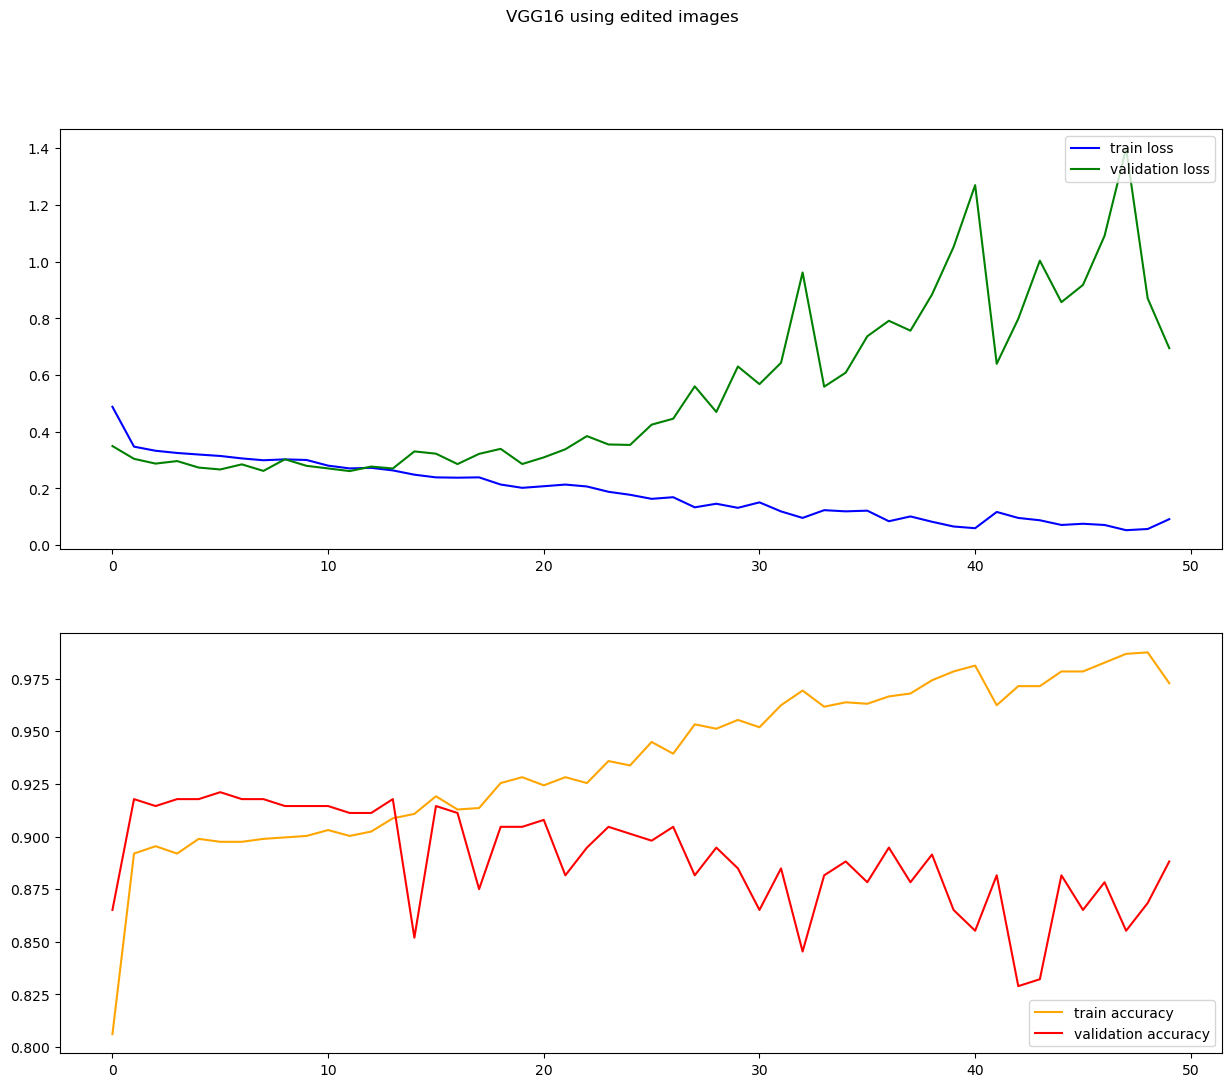

In [6]:
hist = VGG16.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    validation_steps=validation_dataset.samples // BATCH_SIZE,
    verbose=1
)
results = VGG16.evaluate(
    test_dataset,
    batch_size=BATCH_SIZE,
    verbose=1
)

fig = plt.figure(figsize=(15, 12))
fig.suptitle('VGG16 using edited images')

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(hist.history['loss'], color='blue', label='train loss', )
ax1.plot(hist.history['val_loss'], color='green', label='validation loss')
ax1.legend(loc="upper right")
ax2.plot(hist.history['accuracy'], color='orange', label='train accuracy')
ax2.plot(hist.history['val_accuracy'], color='red', label='validation accuracy')
ax2.legend(loc="lower right")
plt.show()